In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline
import seaborn as sns

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
# 重回帰
from sklearn.linear_model import LinearRegression as LR
# 評価関数
from sklearn.metrics import mean_squared_error as MSE

In [106]:
class TrainDataset():
    def __init__(self):        
        
        # 学習データ
        data = pd.read_csv('train.csv')
        data_add = pd.read_csv('train_add.csv')
        data_new = pd.concat([data, data_add])
        
        # スタジアム
        stadium = pd.read_csv('stadium.csv')
        data_all = pd.merge(data_new, stadium, left_on='stadium', right_on='name', how='left') 
        
        # data_allのnameカラムを削除して、data_allに代入してください。
        data_all = data_all.drop(columns=['name'])
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        self.df = self.correction(data_all.copy())
        
        # 目的変数の外れ値は、評価データに存在しないため、init内で処理する
        self.df = self.df[self.df['y'] > 0]
        tmp = self.df['y'] / self.df['capa']
        self.df['y_capa'] = tmp.round(5)
        
        # 説明変数と目的変数に分割する
        df_x = self.df.drop(['y', 'y_capa'], axis=1)
        self.df_y = self.df.loc[:,['y']]
        self.df_y_capa = self.df.loc[:,['y_capa']]
        
        
        # 説明変数の量的データ、質的データ分割
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df_x.copy())
        self.x_desc = self.x_cont.describe()
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        self.DataConv()
        
        print(self.x_cate_conv.info())
        print(self.x_cont_conv.info())
        
    def correction(self, df):

        df['month'] = df['gameday'].apply(self.get_month)
        df['week'] = df['gameday'].apply(self.get_week)
        df['match_num'] = df['match'].apply(self.get_match)
        df['hour'] = df['time'].apply(self.get_hour)
        df['tv_num'] = df['tv'].apply(self.get_num)
        df = df.replace('ザスパ草津','ザスパクサツ群馬')
        df = df.replace('岐阜メモリアルセンター長良川球技メドウ','岐阜メモリアルセンター長良川競技場')
        
        #print('null check')
        #print(df.isnull().sum())
        #print('-------------------------')
        
        return df
    
    def DataChange(self, df_x):
        categ_cols = ['year', 'stage' , 'match', 'match_num' ,'gameday', 'time', 'home' ,'away', 'tv' , 'month' , 'week']
        contin_cols = [ 'match_num' ,'tv_num']
        index_cols = ['id', 'capa']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()
        x_id = df_x[index_cols].copy()
        x_id = x_id.astype('int64')
        
        return x_cate , x_cont  ,x_id
    
    
    # 開催日の月を取り出す
    def get_month(self, x):
        return int(x[0:2])
    
    # 開催日の曜日を取り出す
    def get_week(self, x):
        return x[6:7]
    
    # 開催日の月を取り出す
    def get_hour(self, x):
        return int(x[0:2])
    
    # 第〇節の値を取り出して数値化する
    def get_match(self, x):
        return int(x[x.find('第') + 1: x.find('節')])
    
    # 湿度を数値化する
    def get_humidity(self, x):
        return float(x[:-1])/100
    
    # 放送するテレビ局の数を数える
    def get_num(self, x):
        return len(x.split('／'))

    def dropCol(self):
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=['year', 'gameday', 'tv' ,'match',  'match_num', 'time', 'away' ], axis=1)
        # application_typeは使ってみる
        
        #self.x_cont_conv = self.x_cont_conv.drop(columns=['year'], axis=1)
        # credit_scoreは使ってみる（差があるかは要確認）
        
    def stageConv(self):
        
        col = 'stage'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='Ｊ１']        
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロがＪ２なので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='Ｊ２']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
        
    def monthConv(self):
        
        col = 'month'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='12']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # 12月だけ観客数が多いので、その他は０にする
        row_index = self.x_cate.index[self.x_cate[col]=='03']
        row_index = self.x_cate.index[self.x_cate[col]=='04']
        row_index = self.x_cate.index[self.x_cate[col]=='05']
        row_index = self.x_cate.index[self.x_cate[col]=='06']
        row_index = self.x_cate.index[self.x_cate[col]=='07']
        row_index = self.x_cate.index[self.x_cate[col]=='08']
        row_index = self.x_cate.index[self.x_cate[col]=='09']
        row_index = self.x_cate.index[self.x_cate[col]=='10']
        row_index = self.x_cate.index[self.x_cate[col]=='11']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def weekConv(self):
        
        col = 'week'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='土']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # 土曜日だけ観客数が多いので、その他は０にする
        row_index = self.x_cate.index[self.x_cate[col]=='日']
        row_index = self.x_cate.index[self.x_cate[col]=='月']
        row_index = self.x_cate.index[self.x_cate[col]=='火']
        row_index = self.x_cate.index[self.x_cate[col]=='水']
        row_index = self.x_cate.index[self.x_cate[col]=='木']
        row_index = self.x_cate.index[self.x_cate[col]=='金']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def homeConv(self):
        
        col = 'home'
        
        self.x_cate_conv[col + '_01'] = 0
        self.x_cate_conv[col + '_02'] = 0
        self.x_cate_conv[col + '_03'] = 0
        self.x_cate_conv[col + '_04'] = 0
        self.x_cate_conv[col + '_05'] = 0
        
        self.x_cate_conv[col + '_06'] = 0
        self.x_cate_conv[col + '_07'] = 0
        self.x_cate_conv[col + '_08'] = 0
        self.x_cate_conv[col + '_09'] = 0
        self.x_cate_conv[col + '_10'] = 0
        
        self.x_cate_conv[col + '_11'] = 0
        self.x_cate_conv[col + '_12'] = 0
        self.x_cate_conv[col + '_13'] = 0
        self.x_cate_conv[col + '_14'] = 0
        self.x_cate_conv[col + '_15'] = 0
        
        self.x_cate_conv[col + '_16'] = 0
        self.x_cate_conv[col + '_17'] = 0
        self.x_cate_conv[col + '_18'] = 0
        self.x_cate_conv[col + '_19'] = 0
        self.x_cate_conv[col + '_20'] = 0
        
        self.x_cate_conv[col + '_21'] = 0
        self.x_cate_conv[col + '_22'] = 0
        self.x_cate_conv[col + '_23'] = 0
        self.x_cate_conv[col + '_24'] = 0
        self.x_cate_conv[col + '_25'] = 0
        
        self.x_cate_conv[col + '_26'] = 0
        self.x_cate_conv[col + '_27'] = 0
        self.x_cate_conv[col + '_28'] = 0
        self.x_cate_conv[col + '_29'] = 0
        self.x_cate_conv[col + '_30'] = 0
        
        self.x_cate_conv[col + '_31'] = 0
        #self.x_cate_conv[col + '_32'] = 0
        #self.x_cate_conv[col + '_33'] = 0
        #self.x_cate_conv[col + '_34'] = 0
        #self.x_cate_conv[col + '_35'] = 0
        
        #self.x_cate_conv[col + '_36'] = 0
        #self.x_cate_conv[col + '_37'] = 0
        #self.x_cate_conv[col + '_38'] = 0
        #self.x_cate_conv[col + '_39'] = 0
        #self.x_cate_conv[col + '_40'] = 0
        
        #self.x_cate_conv[col + '_41'] = 0
        #self.x_cate_conv[col + '_42'] = 0
        
        row_index = self.x_cate.index[self.x_cate[col]=='ベガルタ仙台']
        self.x_cate_conv.loc[row_index, col + '_01'] = 1        
        row_index = self.x_cate.index[self.x_cate[col]=='ガンバ大阪']
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2012)].index
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_04'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='セレッソ大阪') & (self.x_cate['year'] == 2014)].index                
        self.x_cate_conv.loc[row_index, col + '_05'] = 1
        
        
        row_index = self.x_cate.index[self.x_cate[col]=='浦和レッズ']
        self.x_cate_conv.loc[row_index, col + '_06'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='清水エスパルス']
        self.x_cate_conv.loc[row_index, col + '_07'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ジュビロ磐田']
        self.x_cate_conv.loc[row_index, col + '_08'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='川崎フロンターレ']
        self.x_cate_conv.loc[row_index, col + '_09'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ヴァンフォーレ甲府']
        self.x_cate_conv.loc[row_index, col + '_10'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='湘南ベルマーレ']
        self.x_cate_conv.loc[row_index, col + '_11'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='名古屋グランパス']
        self.x_cate_conv.loc[row_index, col + '_12'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='松本山雅ＦＣ']
        self.x_cate_conv.loc[row_index, col + '_13'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='サガン鳥栖']
        self.x_cate_conv.loc[row_index, col + '_14'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='大宮アルディージャ']
        self.x_cate_conv.loc[row_index, col + '_15'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='ジェフユナイテッド千葉']
        self.x_cate_conv.loc[row_index, col + '_16'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='アルビレックス新潟']
        self.x_cate_conv.loc[row_index, col + '_17'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='横浜ＦＣ']
        self.x_cate_conv.loc[row_index, col + '_18'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ岐阜']
        self.x_cate_conv.loc[row_index, col + '_19'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ロアッソ熊本']
        self.x_cate_conv.loc[row_index, col + '_20'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='水戸ホーリーホック']
        self.x_cate_conv.loc[row_index, col + '_21'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='京都サンガF.C.']
        self.x_cate_conv.loc[row_index, col + '_22'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='横浜Ｆ・マリノス']
        self.x_cate_conv.loc[row_index, col + '_23'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='徳島ヴォルティス') & (self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_24'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='徳島ヴォルティス') & ~(self.x_cate['year'] == 2014)].index
        self.x_cate_conv.loc[row_index, col + '_25'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ東京']
        self.x_cate_conv.loc[row_index, col + '_26'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='ファジアーノ岡山']
        self.x_cate_conv.loc[row_index, col + '_27'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='鹿島アントラーズ']
        self.x_cate_conv.loc[row_index, col + '_28'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='']
        row_index = self.x_cate[(self.x_cate[col]=='ヴィッセル神戸') & (self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_29'] = 1
        row_index = self.x_cate[(self.x_cate[col]=='ヴィッセル神戸') & ~(self.x_cate['year'] == 2013)].index
        self.x_cate_conv.loc[row_index, col + '_30'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='柏レイソル']
        self.x_cate_conv.loc[row_index, col + '_31'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='コンサドーレ札幌']
        row_index = self.x_cate.index[self.x_cate[col]=='Ｖ・ファーレン長崎']
        row_index = self.x_cate.index[self.x_cate[col]=='サンフレッチェ広島']
        row_index = self.x_cate.index[self.x_cate[col]=='大分トリニータ']
        row_index = self.x_cate.index[self.x_cate[col]=='東京ヴェルディ']
        row_index = self.x_cate.index[self.x_cate[col]=='アビスパ福岡']
        row_index = self.x_cate.index[self.x_cate[col]=='愛媛ＦＣ']
        row_index = self.x_cate.index[self.x_cate[col]=='ギラヴァンツ北九州']
        row_index = self.x_cate.index[self.x_cate[col]=='栃木ＳＣ']
        row_index = self.x_cate.index[self.x_cate[col]=='ＦＣ町田ゼルビア']
        row_index = self.x_cate.index[self.x_cate[col]=='ザスパクサツ群馬']        
        row_index = self.x_cate.index[self.x_cate[col]=='モンテディオ山形']
        row_index = self.x_cate.index[self.x_cate[col]=='ガイナーレ鳥取']
        row_index = self.x_cate.index[self.x_cate[col]=='カターレ富山']
        row_index = self.x_cate.index[self.x_cate[col]=='カマタマーレ讃岐']     
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def addCol(self):
        
        col = 'special'
        
        #self.x_cate_conv['sereso'] = 0
        #self.x_cate_conv['sereso'][(self.x_cate_conv['home'] == 'セレッソ大阪') & (self.x_cate_conv['week']=='土')] = 1
        #self.x_cate_conv['sereso'][(self.x_cate_conv['away'] == 'セレッソ大阪') & (self.x_cate_conv['week']=='土')] = 1
        
        self.x_cate_conv['tokusima'] = 0
        self.x_cate_conv['tokusima'][(self.x_cate_conv['away'] == '徳島ヴォルティス') & (self.x_cate['year'] == 2014)] = 1
        
        self.x_cate_conv['last_match'] = 0
        self.x_cate_conv['last_match'][((self.x_cate_conv['match_num'] == 33) | (self.x_cate_conv['match_num'] == 34)) & (self.x_cate_conv['stage'] == 'Ｊ１')] = 1
        self.x_cate_conv['last_match'][((self.x_cate_conv['match_num'] == 41) | (self.x_cate_conv['match_num'] == 42)) & (self.x_cate_conv['stage'] == 'Ｊ２')] = 1
        
        self.x_cate_conv['first_match'] = 0
        self.x_cate_conv['first_match'][((self.x_cate_conv['match_num'] == 1) | (self.x_cate_conv['match_num'] == 2))] = 1
        
        #self.x_cate_conv['forlan'] = 0
        #self.x_cate_conv['forlan'][(self.x_cate_conv['year'] == 2014) & (self.x_cate_conv['away'] == 'セレッソ大阪')] = 1
        
        #
    
    def train_Split(self):
        
        # 訓練データと検証データに分割
        x_train_cate, x_test_cate ,y_train, y_test = train_test_split(self.x_cate_conv, self.df_y, test_size=0.2, random_state=3) 
        
        # カテゴリデータと同じ行数分数値データを抽出する (id も訓練データと検証データに分ける)
        ### 訓練データ
        row_index = x_train_cate.index.values
        x_train_cont = self.x_cont_conv.loc[row_index, :]
        self.X_train_id = self.x_id.loc[row_index, :]
        self.X_train_id.reset_index(drop=True, inplace=True)
        y_train_capa = self.df_y_capa.loc[row_index, :]
        
        ###　検証データ
        row_index = x_test_cate.index.values
        x_test_cont = self.x_cont_conv.loc[row_index, :]
        self.X_test_id = self.x_id.loc[row_index, :]
        self.X_test_id.reset_index(drop=True, inplace=True)
        y_test_capa = self.df_y_capa.loc[row_index, :]
        
        x_train = pd.concat([x_train_cate , x_train_cont] , axis=1)
        x_test = pd.concat([x_test_cate , x_test_cont] , axis=1)
        
        
        
        self.X_train = np.array(x_train)
        self.X_test = np.array(x_test)
        self.Y_train = np.array(y_train)
        self.Y_test = np.array(y_test)
        self.Y_train_capa = np.array(y_train_capa)
        self.Y_test_capa = np.array(y_test_capa)
        
        self.coti_size = self.x_cont.shape[1]
        self.in_size  = self.X_train.shape[1]
        self.out_size = self.Y_train.shape[1]  
    
    def DataConv(self):
        self.addCol()
        
        self.stageConv()
        #self.termConv()
        self.monthConv()
        self.weekConv()
        self.homeConv()
        
        self.dropCol()        
        self.train_Split()
        

In [107]:
train_dataset = TrainDataset()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 1952
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   tokusima     1952 non-null   int64
 1   last_match   1952 non-null   int64
 2   first_match  1952 non-null   int64
 3   stage_1      1952 non-null   int64
 4   month_1      1952 non-null   int64
 5   week_1       1952 non-null   int64
 6   home_01      1952 non-null   int64
 7   home_02      1952 non-null   int64
 8   home_03      1952 non-null   int64
 9   home_04      1952 non-null   int64
 10  home_05      1952 non-null   int64
 11  home_06      1952 non-null   int64
 12  home_07      1952 non-null   int64
 13  home_08      1952 non-null   int64
 14  home_09      1952 non-null   int64
 15  home_10      1952 non-null   int64
 16  home_11      1952 non-null   int64
 17  home_12      1952 non-null   int64
 18  home_13      1952 non-null   int64
 19  home_14      1952 non-null   int64
 20  home_15 

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplot

In [108]:
train_dataset.x_cate

,year,stage,match,match_num,gameday,time,home,away,tv,month,week
0,2012,Ｊ１,第１節第１日,1,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,スカパー／ｅ２／スカパー光／ＮＨＫ総合,3,土
1,2012,Ｊ１,第１節第１日,1,03/10(土),14:04,名古屋グランパス,清水エスパルス,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,3,土
2,2012,Ｊ１,第１節第１日,1,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,3,土
3,2012,Ｊ１,第１節第１日,1,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,スカパー／ｅ２／スカパー光／ＮＨＫ広島,3,土
4,2012,Ｊ１,第１節第１日,1,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,3,土
...,...,...,...,...,...,...,...,...,...,...,...
1948,2014,Ｊ２,第２２節第１日,22,07/20(日),18:03,水戸ホーリーホック,ザスパクサツ群馬,スカパー！／スカパー！プレミアムサービス,7,日
1949,2014,Ｊ２,第２２節第１日,22,07/20(日),19:04,愛媛ＦＣ,京都サンガF.C.,スカパー！／スカパー！プレミアムサービス,7,日
1950,2014,Ｊ２,第２３節第１日,23,07/26(土),18:03,横浜ＦＣ,ジュビロ磐田,スカパー！／スカパー！プレミアムサービス,7,土
1951,2014,Ｊ２,第２４節第１日,24,07/30(水),19:03,水戸ホーリーホック,Ｖ・ファーレン長崎,スカパー！／スカパー！プレミアムサービス,7,水


### 訓練データの読み込み

In [109]:
class TestDataset(TrainDataset):
    def __init__(self, x_desc):
        
        # 学習データ
        data = pd.read_csv('test.csv')

        # スタジアム
        self.stadium = pd.read_csv('stadium.csv')
        data_all = pd.merge(data, self.stadium, left_on='stadium', right_on='name', how='left') 
        
        # data_allのnameカラムを削除して、data_allに代入してください。
        data_all = data_all.drop(columns=['name'])
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        data_all = self.correction(data_all.copy())
        
        # 目的変数の格納
        self.x_cate , self.x_cont, self.x_id = self.DataChange(data_all.copy())
        self.x_desc = x_desc
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        # データの加工（標準化や対数化など）
        #self.std_scale = 0
        self.max_scale = 0
        #self.dobule_scale = 0
        #self.polynomialFlg = 0
        #self.binSplitFlg = 0
        #self.logFlg  = 0
        self.DataConv()
        
        #self.NpToPy()
        #self.num = len(self.x_cate)
        self.num = len(self.x_cate_conv)
        self.coti_size = self.x_cont_conv.shape[1]

    def __getitem__(self, index):
        return self.X_vat[index]
    
    def __len__(self):
        return self.num
    
    def train_Split(self):
        
        #x_temp = self.x_cont.copy()
        tmp_cate = np.array(self.x_cate_conv)
        tmp_cont = np.array(self.x_cont_conv)
        
        # numpy の値を torch の値に変換する
        self.X_vat_cate = tmp_cate
        self.X_vat_cont = tmp_cont
 


In [110]:
test_dataset = TestDataset(train_dataset.x_desc)

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\ipykernel_launcher.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takasaki\Anaconda3\envs\matplot

# モデル定義

In [111]:
lr = LR()
lr.fit(train_dataset.X_train, train_dataset.Y_train_capa)

LinearRegression()

# 予測する

### 訓練データ

In [112]:
# 予測
y_pred_train = lr.predict(train_dataset.X_train)
df_pred_train = pd.DataFrame(y_pred_train , columns=['vat_tmp'])

# capa を結合して観客数を求める
df_pred_train = pd.concat([train_dataset.X_train_id , df_pred_train] , axis=1)
df_pred_train['vat'] = df_pred_train['vat_tmp'] * df_pred_train['capa']

y_pred_train = np.round(np.array(df_pred_train['vat']))
y_pred_train = y_pred_train.reshape(-1,1)
print(y_pred_train)
print(train_dataset.Y_train)

[[16715.]
 [ 5904.]
 [36904.]
 ...
 [ 4017.]
 [ 8007.]
 [ 6144.]]
[[14388]
 [ 5318]
 [46649]
 ...
 [ 3706]
 [10573]
 [ 3560]]


In [113]:
rmse_train = np.sqrt(MSE(train_dataset.Y_train, y_pred_train))
print(rmse_train)

3749.1925201102617


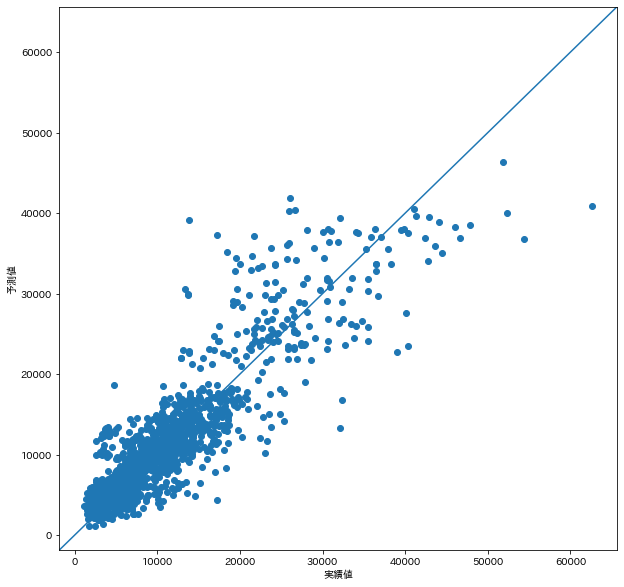

In [114]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定する
plt.figure(figsize=(10,10))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(train_dataset.Y_train,y_pred_train)

# 値域を揃える為に、y_test、y_pred_testの両方を見た上での最小値と最大値を求める
min_value = min(min(train_dataset.Y_train), min(y_pred_train)) - 3000
max_value = max(max(train_dataset.Y_train), max(y_pred_train)) + 3000

# 3.最小値と最大値を使い、x軸およびy軸の値域を指定する
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 4.対角線を描く
plt.plot([min_value,max_value],[min_value,max_value])

#x軸とy軸に名前を付ける
plt.xlabel("実績値")
plt.ylabel("予測値")

# 可視化結果を表示する為に必要な関数
plt.show()

### 検証データ

In [115]:
y_pred_test = lr.predict(train_dataset.X_test)
df_pred_test = pd.DataFrame(y_pred_test , columns=['vat_tmp'])

# capa を結合して観客数を求める
df_pred_test = pd.concat([train_dataset.X_test_id , df_pred_test] , axis=1)
df_pred_test['vat'] = df_pred_test['vat_tmp'] * df_pred_test['capa']

y_pred_test = np.round(np.array(df_pred_test['vat']))
y_pred_test = y_pred_test.reshape(-1,1)

In [116]:
rmse_test = np.sqrt(MSE(train_dataset.Y_test, y_pred_test))
print(rmse_test)

3749.9348778659205


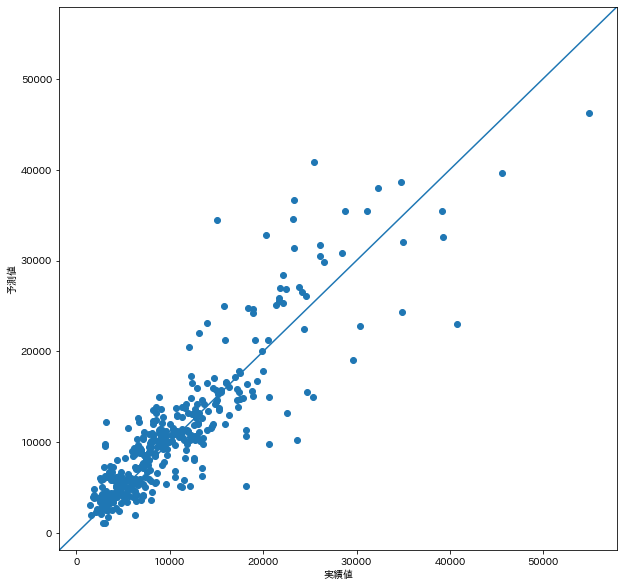

In [103]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定する
plt.figure(figsize=(10,10))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(train_dataset.Y_test,y_pred_test)

# 値域を揃える為に、y_test、y_pred_testの両方を見た上での最小値と最大値を求める
min_value = min(min(train_dataset.Y_test), min(y_pred_test)) - 3000
max_value = max(max(train_dataset.Y_test), max(y_pred_test)) + 3000

# 3.最小値と最大値を使い、x軸およびy軸の値域を指定する
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 4.対角線を描く
plt.plot([min_value,max_value],[min_value,max_value])

#x軸とy軸に名前を付ける
plt.xlabel("実績値")
plt.ylabel("予測値")

# 可視化結果を表示する為に必要な関数
plt.show()

# 残差確認

In [105]:

tmp = pd.concat([df_pred_train  ,df_pred_test] )
tmp = tmp.drop(columns=['capa', 'vat_tmp'] , axis=1)

data = pd.merge(train_dataset.df, tmp , on='id' , how='left')
data['res'] = data['y']  - data['vat']
data['res2'] = np.abs(data['res'])
data = data.sort_values(by = 'res2', ascending = False )

data.head(40)




,id,y,year,stage,match,gameday,time,home,away,stadium,...,capa,month,week,match_num,hour,tv_num,y_capa,vat,res,res2
1358,15669,13809,2014,Ｊ１,第１節第１日,03/01(土),14:05,ヴァンフォーレ甲府,鹿島アントラーズ,国立競技場,...,54224,3,土,1,14,4,0.25467,40593.215658,-26784.215658,26784.215658
1843,15127,62632,2013,Ｊ１,第３３節第１日,11/30(土),14:04,横浜Ｆ・マリノス,アルビレックス新潟,日産スタジアム,...,72327,11,土,33,14,3,0.86596,41705.673926,20926.326074,20926.326074
922,15113,17183,2013,Ｊ１,第３１節第１日,11/10(日),19:05,ベガルタ仙台,浦和レッズ,宮城スタジアム,...,49133,11,日,31,19,3,0.34972,37989.923136,-20806.923136,20806.923136
1806,14839,15051,2013,Ｊ１,第１節第１日,03/02(土),14:05,セレッソ大阪,アルビレックス新潟,ヤンマースタジアム長居,...,47816,3,土,1,14,4,0.31477,34455.448332,-19404.448332,19404.448332
1384,15698,32099,2014,Ｊ１,第４節第１日,03/23(日),15:04,鹿島アントラーズ,セレッソ大阪,県立カシマサッカースタジアム,...,40728,3,日,4,15,2,0.78813,13826.602583,18272.397417,18272.397417
1417,15736,40761,2014,Ｊ１,第８節第１日,04/19(土),16:04,ＦＣ東京,セレッソ大阪,味の素スタジアム,...,49970,4,土,8,16,2,0.81571,23019.790060,17741.209940,17741.209940
721,14887,13384,2013,Ｊ１,第６節第１日,04/13(土),19:04,セレッソ大阪,大宮アルディージャ,ヤンマースタジアム長居,...,47816,4,土,6,19,3,0.27991,30620.273161,-17236.273161,17236.273161
917,15107,40371,2013,Ｊ１,第３１節第１日,11/10(日),13:05,ＦＣ東京,セレッソ大阪,味の素スタジアム,...,49970,11,日,31,13,2,0.80790,23432.595707,16938.404293,16938.404293
1462,15787,54350,2014,Ｊ１,第１４節第１日,05/17(土),14:04,浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,...,63700,5,土,14,14,3,0.85322,38022.990209,16327.009791,16327.009791
1750,14298,18487,2012,Ｊ１,第３４節第１日,12/01(土),15:34,セレッソ大阪,川崎フロンターレ,ヤンマースタジアム長居,...,47816,12,土,34,15,2,0.38663,34590.622984,-16103.622984,16103.622984


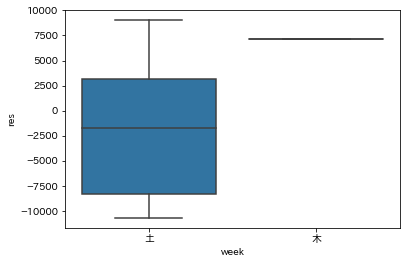

In [19]:
# awayチームがセレッソ大阪のデータで、yearをx軸、yをy軸にした箱ひげ図を描いてください。
sns.boxplot(data=data[(data['home'] == '浦和レッズ') & (data['year'] == 2012)], x='week', y='res')

# 可視化結果を表示する為に必要な関数
plt.show()


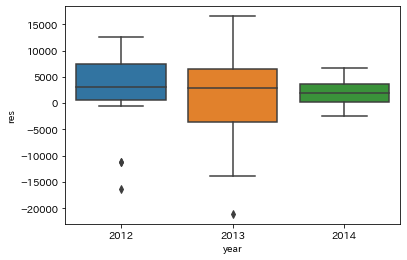

In [17]:
# awayチームがセレッソ大阪のデータで、yearをx軸、yをy軸にした箱ひげ図を描いてください。
sns.boxplot(data=data[data['away'] == '浦和レッズ'], x='year', y='res')

# 可視化結果を表示する為に必要な関数
plt.show()
